# This is an example of using real experimental data to plot the HK plane
Requires:
- six angles(motor position) 
- image stack. 

Here skxray.core.recip.process_to_q function is used to convert to Q
(reciprocal space) and then that data is gridded using nsls2.core.py
-> process_grid function.


In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import numpy.ma as ma
import os
import matplotlib.pyplot as plt
from skxray.core import recip
from skxray.core.utils import grid3d
import zipfile
import six
import time as ttime
%matplotlib inline

In [2]:
def recip_ex(detector_size, pixel_size, calibrated_center, dist_sample,
             ub_mat, wavelength, motors, i_stack, H_range, K_range, L_range):
    # convert to Q space
    q_values = recip.process_to_q(motors, detector_size, pixel_size,
                                  calibrated_center, dist_sample,
                                  wavelength, ub_mat)

    # minimum and maximum values of the voxel
    q_min = np.array([H_range[0], K_range[0], L_range[0]])
    q_max = np.array([H_range[1], K_range[1], L_range[1]])

    # no. of bins
    dqn = np.array([40, 40, 1])

    # process the grid values
    (grid_data, grid_occu, std_err,
     grid_out, bounds) = grid3d(q_values, i_stack, dqn[0], dqn[1],
                                            dqn[2])

    grid = np.mgrid[0:dqn[0], 0:dqn[1], 0:dqn[2]]
    r = (q_max - q_min) / dqn

    X = grid[0] * r[0] + q_min[0]
    Y = grid[1] * r[1] + q_min[1]
    Z = grid[2] * r[2] + q_min[2]

    # creating a mask
    _mask = grid_occu <= 10
    grid_mask_data = ma.masked_array(grid_data, _mask)
    grid_mask_std_err = ma.masked_array(std_err, _mask)
    grid_mask_occu = ma.masked_array(grid_occu, _mask)

    return X, Y, Z, grid_mask_data


In [3]:
def plot_slice(ax, x, y, i_slice, lx, H_range, K_range):
    # plot the HK plane

    i_slice_range = [0.006, 0.0115]

    cnt = ax.contourf(x, y, i_slice, np.linspace(i_slice_range[0],
                                                   i_slice_range[1],
                                                   50, endpoint=True),
                        cmap='hot',
                        extend='both')
    subp.axis('scaled')
    subp.set_xlim(H_range)
    subp.set_ylim(K_range)

    subp.set_xlabel("H", size=10)
    subp.set_ylabel("K", size=10)

    subp.tick_params(labelsize=9)

    cbar = plt.colorbar(cnt, ticks=np.linspace(i_slice_range[0],
                                               i_slice_range[1],
                                               3, endpoint=True),
                        format='%.4f')
    cbar.ax.tick_params(labelsize=8)


In [4]:
def get_data(X, Y, grid_mask_data, plane):
    HKL = 'HKL'
    for i in plane:
        HKL = HKL.replace(i, '')

    HH = X[:, :, :].squeeze()
    H = X[:, 0, 0]
    KK = Y[:, :, :].squeeze()
    K = Y[0, :, 0]

    i_slice = grid_mask_data[:, :, :].squeeze()  # intensity slice
    lx = eval(plane[0])

    return i_slice, lx

### define some metadata

In [5]:
H_range = [-0.270, -0.200]
K_range = [+0.010, -0.010]
L_range = [+1.370, +1.410]

detector_size = (256, 256)
pixel_size = (0.0135*8, 0.0135*8)  # (mm)
calibrated_center = (256/2.0, 256/2.0)  # (mm)
dist_sample = 355.0  # (mm)

# ub matrix data
ub_mat = np. array([[-1.39772305e-01, -1.65559565e+00, -1.40501716e-02],
                    [-1.65632438e+00, 1.39853170e-01, -1.84650965e-04],
                    [4.79923390e-03, 4.91318724e-02, -4.72922724e-01]])

# wavelength data
wavelength = np.array([13.28559417])

# six angles data
motors = np.array([[102.3546, 77.874608, -90., 0., 0., 1.0205],
                   [102.6738, 78.285008, -90., 0., 0., 1.0575],
                   [102.9969, 78.696608, -90., 0., 0., 1.0945],
                   [103.3236, 79.108808, -90., 0., 0., 1.1315],
                   [103.6545, 79.521908, -90., 0., 0., 1.1685],
                   [103.9893, 79.935908, -90., 0., 0., 1.2055],
                   [104.3283, 80.350808, -90., 0., 0., 1.243],
                   [104.6712, 80.766608, -90., 0., 0., 1.28],
                   [105.018, 81.183308, -90., 0., 0., 1.317],
                   [105.369, 81.600908, -90., 0., 0., 1.354],
                   [105.7242, 82.019408, -90., 0., 0., 1.391],
                   [106.0836, 82.438808, -90., 0., 0., 1.428],
                   [106.4472, 82.859108, -90., 0., 0., 1.465],
                   [106.815, 83.280608, -90., 0., 0., 1.502],
                   [107.187, 83.703308, -90., 0., 0., 1.539],
                   [107.5632, 84.126608, -90., 0., 0., 1.576],
                   [107.9442, 84.551108, -90.,  0., 0., 1.6135],
                   [108.3291, 84.976808, -90.,  0., 0., 1.6505],
                   [108.7188, 85.403709, -90.,  0., 0., 1.6875],
                   [109.113, 85.831509, -90.,  0., 0., 1.7245],
                   [109.5117, 86.260509, -90.,  0., 0., 1.7615],
                   [109.9149, 86.690709, -90.,  0., 0., 1.7985],
                   [110.3229, 87.122109, -90.,  0., 0., 1.8355],
                   [110.7357, 87.554709, -90.,  0., 0., 1.8725],
                   [111.153, 87.988809, -90.,  0., 0., 1.91],
                   [111.5754, 88.424109, -90., 0., 0., 1.947],
                   [112.0026, 88.860609, -90., 0., 0., 1.984],
                   [112.4349, 89.298609, -90., 0., 0., 2.021],
                   [112.8723, 89.737809, -90., 0., 0., 2.058],
                   [113.3145, 90.178809, -90., 0., 0., 2.095],
                   [113.7621, 90.621009, -90., 0., 0., 2.132],
                   [114.2151, 91.065009, -90., 0., 0., 2.169],
                   [114.6735, 91.510209, -90., 0., 0., 2.2065]])

# Data folder path
# path = "LSCO_Nov12_broker"

### Load the data

In [6]:
# intensity of the image stack data
try:
    i_stack = np.load(os.path.join("LSCO_Nov12_broker", "i_stack.npy"))
except IOError:
    zipfile.ZipFile(os.path.join("LSCO_Nov12_broker.zip")).extractall()
    i_stack = np.load(os.path.join("LSCO_Nov12_broker", "i_stack.npy"))


In [7]:
X, Y, Z, grid_mask_data = recip_ex(detector_size, pixel_size,
                                   calibrated_center, dist_sample,
                                   ub_mat, wavelength, motors, i_stack,
                                   H_range, K_range, L_range)

i_slice, lx = get_data(X, Y, grid_mask_data, plane='HK')

x = X.reshape(40, 40)
y = Y.reshape(40, 40)


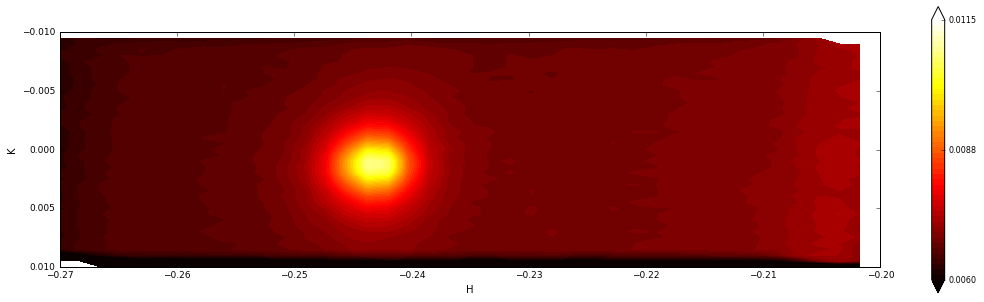

In [9]:
f = plt.figure("HK plane", figsize=(15, 5))
plt.subplots_adjust(left=0.10, bottom=0.155555,
                    right=1.05, top=0.95,
                    wspace=0.2, hspace=0.45)
subp = f.add_subplot(111)
plot_slice(subp, x, y, i_slice, lx, H_range, K_range)
plt.show()

In [10]:
import skxray

In [11]:
skxray.__version__

'0.0.4+95.gb764d5c'